In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf
from google.colab import drive
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from transformers import SwinModel

# Dataset

In [ ]:
# Mount Google Drive (only for Colab)
drive.mount('/content/drive')

# ========================================================================
# 1. Dataset Configuration
# ========================================================================
dataset_paths = {
    'Normal': '/content/drive/MyDrive/Normal and Osteoporosis Binary Classification Dataset/normal/',
    'Osteoporosis': '/content/drive/MyDrive/Normal and Osteoporosis Binary Classification Dataset/osteoporosis/'
}

# ========================================================================
# 2. Image Loading & Preprocessing
# ========================================================================
def load_images_and_labels(folder_path, label):
    images = []
    labels = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(folder_path, filename)
            try:
                # Load image and verify successful read
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Could not read image {img_path}")
                    continue

                # Critical Fix 1: Resize to ViT's required 224x224
                img = cv2.resize(img, (224, 224))

                # Critical Fix 2: Convert BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Critical Fix 3: Convert to channels-first format
                img = np.transpose(img, (2, 0, 1))  # (3, 224, 224)

                # Critical Fix 4: Normalize to [-1, 1] range
                img = (img.astype(np.float32) / 127.5) - 1.0

                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return np.array(images), np.array(labels)

# ========================================================================
# 3. Load and Prepare Data
# ========================================================================
# Load datasets
normal_images, normal_labels = load_images_and_labels(dataset_paths['Normal'], 0)
osteo_images, osteo_labels = load_images_and_labels(dataset_paths['Osteoporosis'], 1)

# Combine and shuffle data
x_data = np.concatenate([normal_images, osteo_images], axis=0)
y_data = np.concatenate([normal_labels, osteo_labels], axis=0)

# Random shuffle with fixed seed for reproducibility
np.random.seed(42)
shuffle_idx = np.random.permutation(len(x_data))
x_data = x_data[shuffle_idx]
y_data = y_data[shuffle_idx]

# ========================================================================
# 4. Train/Validation/Test Split
# ========================================================================
# Stratified split to maintain class balance
x_train_val, x_test, y_train_val, y_test = train_test_split(
    x_data, y_data,
    test_size=0.2,
    stratify=y_data,
    random_state=42
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val,
    test_size=0.1,  # 10% of training for validation
    stratify=y_train_val,
    random_state=42
)

Mounted at /content/drive


In [ ]:
print(f'Number of Normal Images: {len(normal_images)}')
print(f'Number of Oestroporosis Images: {len(osteo_images)}')

Number of Normal Images: 186
Number of Oestroporosis Images: 186


In [ ]:
# Step 2: Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Step 3: DWT Implementation
def dwt_haar(img):
    """Performs Haar wavelet transform on a batch of images."""
    # img shape: (batch, channels, height, width)
    batch, channels, h, w = img.shape

    # Split rows into even and odd indices
    even_rows = img[:, :, 0::2, :]
    odd_rows = img[:, :, 1::2, :]

    # Compute row-wise averages and differences
    avg_rows = (even_rows + odd_rows) / 2
    diff_rows = (even_rows - odd_rows) / 2

    # Split columns for avg_rows (LL and HL)
    even_cols_avg = avg_rows[:, :, :, 0::2]
    odd_cols_avg = avg_rows[:, :, :, 1::2]
    LL = (even_cols_avg + odd_cols_avg) / 2
    HL = (even_cols_avg - odd_cols_avg) / 2

    # Split columns for diff_rows (LH and HH)
    even_cols_diff = diff_rows[:, :, :, 0::2]
    odd_cols_diff = diff_rows[:, :, :, 1::2]
    LH = (even_cols_diff + odd_cols_diff) / 2
    HH = (even_cols_diff - odd_cols_diff) / 2

    return torch.cat([LL, HL, LH, HH], dim=1)

# Step 4: Dataset Class (unchanged)
class NumpyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.x_data[idx]).float()
        label = torch.tensor(self.y_data[idx], dtype=torch.float32)
        return image, label

Using device: cuda


# Base Swin Transformer Model

In [ ]:
# Step 5: Modified ViT Model with DWT Processing
from transformers import SwinModel

class SwinBinaryClassifier(nn.Module):
    def __init__(self, pretrained_model='microsoft/swin-base-patch4-window7-224'):
        super().__init__()
        self.swin = SwinModel.from_pretrained(pretrained_model)
        self.classifier = nn.Linear(self.swin.config.hidden_size * 4, 1)
        self.sigmoid = nn.Sigmoid()

        # Freeze Swin parameters
        for param in self.swin.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Apply Haar DWT
        x_dwt = dwt_haar(x)
        batch_size = x_dwt.size(0)

        # Reshape and process each subband
        x_dwt = x_dwt.view(batch_size, 4, 3, 112, 112)
        swin_outputs = []

        for i in range(4):
            subband = x_dwt[:, i, :, :, :]
            subband_up = F.interpolate(subband, size=(224, 224),
                                     mode='bilinear', align_corners=False)
            outputs = self.swin(subband_up)
            # Use mean pooling over sequence dimension
            pooled = outputs.last_hidden_state.mean(dim=1)
            swin_outputs.append(pooled)

        # Concatenate and classify
        combined = torch.cat(swin_outputs, dim=1)
        return self.sigmoid(self.classifier(combined))

# Initialize Swin model
model = SwinBinaryClassifier().to(device)

# Step 8: Loss and Optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [ ]:
batch_size = 32
train_dataset = NumpyDataset(x_train, y_train)
val_dataset = NumpyDataset(x_val, y_val)
test_dataset = NumpyDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# --------------------------
# 4. Training Loop
# --------------------------
num_epochs = 500
best_val_loss = float('inf')
patience = 20
history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []}

print(f"\n{'='*50}")
print(f"Starting training of {model.__class__.__name__}")
print(f"Batch size: {batch_size}, Epochs: {num_epochs}")
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
print(f"{'='*50}\n")

for epoch in range(num_epochs):
    epoch_start = time.time()

    # Training phase
    model.train()
    train_loss = 0.0
    with tqdm(train_loader, desc=f"Epoch {epoch+1:3d}/{num_epochs} [Train]", unit="batch") as pbar:
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    # Validation phase
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            predicted = (outputs >= 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate metrics
    epoch_train_loss = train_loss / len(train_dataset)
    epoch_val_loss = val_loss / len(val_dataset)
    val_acc = correct / total
    current_lr = optimizer.param_groups[0]['lr']

    # Update scheduler and history
    scheduler.step(epoch_val_loss)
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1

    # Epoch reporting
    epoch_time = time.time() - epoch_start
    print(f"\nEpoch {epoch+1:3d}/{num_epochs} | Time: {epoch_time:.1f}s")
    print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    print(f"Val Acc: {val_acc:.4f} | LR: {current_lr:.2e}")
    print(f"Early stopping counter: {patience_counter}/{patience}")
    print("-" * 60)

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


Starting training of SwinBinaryClassifier
Batch size: 32, Epochs: 500
Train samples: 267, Val samples: 30



Epoch   1/500 [Train]: 100%|██████████| 9/9 [00:14<00:00,  1.63s/batch, loss=0.6273]



Epoch   1/500 | Time: 20.3s
Train Loss: 0.6989 | Val Loss: 0.6924
Val Acc: 0.5000 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch   2/500 [Train]: 100%|██████████| 9/9 [00:12<00:00,  1.39s/batch, loss=0.6248]



Epoch   2/500 | Time: 15.0s
Train Loss: 0.6417 | Val Loss: 0.5686
Val Acc: 0.7667 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch   3/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.46s/batch, loss=0.6192]



Epoch   3/500 | Time: 17.6s
Train Loss: 0.5628 | Val Loss: 0.5220
Val Acc: 0.7333 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch   4/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.50s/batch, loss=0.4475]



Epoch   4/500 | Time: 16.0s
Train Loss: 0.5277 | Val Loss: 0.5004
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch   5/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.49s/batch, loss=0.4282]



Epoch   5/500 | Time: 15.9s
Train Loss: 0.5274 | Val Loss: 0.4910
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch   6/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.45s/batch, loss=0.5144]



Epoch   6/500 | Time: 15.5s
Train Loss: 0.4903 | Val Loss: 0.4804
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch   7/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.45s/batch, loss=0.5493]



Epoch   7/500 | Time: 15.4s
Train Loss: 0.4745 | Val Loss: 0.4706
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch   8/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.45s/batch, loss=0.4409]



Epoch   8/500 | Time: 14.7s
Train Loss: 0.4677 | Val Loss: 0.4706
Val Acc: 0.8333 | LR: 1.00e-03
Early stopping counter: 1/20
------------------------------------------------------------


Epoch   9/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.5901]



Epoch   9/500 | Time: 15.8s
Train Loss: 0.4543 | Val Loss: 0.4577
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch  10/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.5677]



Epoch  10/500 | Time: 15.7s
Train Loss: 0.4667 | Val Loss: 0.4452
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch  11/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.46s/batch, loss=0.3390]



Epoch  11/500 | Time: 14.8s
Train Loss: 0.4592 | Val Loss: 0.4452
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 1/20
------------------------------------------------------------


Epoch  12/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.46s/batch, loss=0.5047]



Epoch  12/500 | Time: 17.6s
Train Loss: 0.4285 | Val Loss: 0.4356
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch  13/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.5245]



Epoch  13/500 | Time: 16.3s
Train Loss: 0.4365 | Val Loss: 0.4323
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch  14/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.50s/batch, loss=0.4505]



Epoch  14/500 | Time: 15.2s
Train Loss: 0.4175 | Val Loss: 0.4345
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 1/20
------------------------------------------------------------


Epoch  15/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.49s/batch, loss=0.2532]



Epoch  15/500 | Time: 15.9s
Train Loss: 0.4223 | Val Loss: 0.4289
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch  16/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.3051]



Epoch  16/500 | Time: 15.8s
Train Loss: 0.4217 | Val Loss: 0.4219
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch  17/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.6869]



Epoch  17/500 | Time: 14.9s
Train Loss: 0.3934 | Val Loss: 0.4225
Val Acc: 0.8333 | LR: 1.00e-03
Early stopping counter: 1/20
------------------------------------------------------------


Epoch  18/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.4435]



Epoch  18/500 | Time: 15.0s
Train Loss: 0.4048 | Val Loss: 0.4254
Val Acc: 0.8333 | LR: 1.00e-03
Early stopping counter: 2/20
------------------------------------------------------------


Epoch  19/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.1896]



Epoch  19/500 | Time: 14.8s
Train Loss: 0.3987 | Val Loss: 0.4240
Val Acc: 0.8333 | LR: 1.00e-03
Early stopping counter: 3/20
------------------------------------------------------------


Epoch  20/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.4196]



Epoch  20/500 | Time: 14.9s
Train Loss: 0.3882 | Val Loss: 0.4236
Val Acc: 0.8333 | LR: 1.00e-03
Early stopping counter: 4/20
------------------------------------------------------------


Epoch  21/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.4417]



Epoch  21/500 | Time: 15.7s
Train Loss: 0.3817 | Val Loss: 0.4204
Val Acc: 0.8333 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch  22/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.4021]



Epoch  22/500 | Time: 14.8s
Train Loss: 0.3916 | Val Loss: 0.4261
Val Acc: 0.8333 | LR: 1.00e-03
Early stopping counter: 1/20
------------------------------------------------------------


Epoch  23/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.5126]



Epoch  23/500 | Time: 15.7s
Train Loss: 0.3869 | Val Loss: 0.4162
Val Acc: 0.7667 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch  24/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.3668]



Epoch  24/500 | Time: 14.9s
Train Loss: 0.3693 | Val Loss: 0.4221
Val Acc: 0.8333 | LR: 1.00e-03
Early stopping counter: 1/20
------------------------------------------------------------


Epoch  25/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.4228]



Epoch  25/500 | Time: 14.9s
Train Loss: 0.3682 | Val Loss: 0.4171
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 2/20
------------------------------------------------------------


Epoch  26/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.3608]



Epoch  26/500 | Time: 15.7s
Train Loss: 0.3573 | Val Loss: 0.4133
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch  27/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.3544]



Epoch  27/500 | Time: 14.9s
Train Loss: 0.3623 | Val Loss: 0.4291
Val Acc: 0.8333 | LR: 1.00e-03
Early stopping counter: 1/20
------------------------------------------------------------


Epoch  28/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.6000]



Epoch  28/500 | Time: 15.7s
Train Loss: 0.3716 | Val Loss: 0.4103
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch  29/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.3412]



Epoch  29/500 | Time: 14.9s
Train Loss: 0.3524 | Val Loss: 0.4186
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 1/20
------------------------------------------------------------


Epoch  30/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.6374]



Epoch  30/500 | Time: 15.8s
Train Loss: 0.3578 | Val Loss: 0.4056
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch  31/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.4005]



Epoch  31/500 | Time: 14.9s
Train Loss: 0.3390 | Val Loss: 0.4186
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 1/20
------------------------------------------------------------


Epoch  32/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.2899]



Epoch  32/500 | Time: 14.9s
Train Loss: 0.3437 | Val Loss: 0.4099
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 2/20
------------------------------------------------------------


Epoch  33/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.3542]



Epoch  33/500 | Time: 15.0s
Train Loss: 0.3315 | Val Loss: 0.4133
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 3/20
------------------------------------------------------------


Epoch  34/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.3801]



Epoch  34/500 | Time: 14.9s
Train Loss: 0.3310 | Val Loss: 0.4061
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 4/20
------------------------------------------------------------


Epoch  35/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.5546]



Epoch  35/500 | Time: 14.9s
Train Loss: 0.3280 | Val Loss: 0.4092
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 5/20
------------------------------------------------------------


Epoch  36/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.2344]



Epoch  36/500 | Time: 14.9s
Train Loss: 0.3283 | Val Loss: 0.4091
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 6/20
------------------------------------------------------------


Epoch  37/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.2760]



Epoch  37/500 | Time: 14.9s
Train Loss: 0.3203 | Val Loss: 0.4065
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 7/20
------------------------------------------------------------


Epoch  38/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.4279]



Epoch  38/500 | Time: 14.9s
Train Loss: 0.3081 | Val Loss: 0.4065
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 8/20
------------------------------------------------------------


Epoch  39/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.3016]



Epoch  39/500 | Time: 14.9s
Train Loss: 0.3233 | Val Loss: 0.4056
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 9/20
------------------------------------------------------------


Epoch  40/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.3186]



Epoch  40/500 | Time: 14.9s
Train Loss: 0.3199 | Val Loss: 0.4059
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 10/20
------------------------------------------------------------


Epoch  41/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.2268]



Epoch  41/500 | Time: 15.7s
Train Loss: 0.3145 | Val Loss: 0.4044
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 0/20
------------------------------------------------------------


Epoch  42/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.5135]



Epoch  42/500 | Time: 14.9s
Train Loss: 0.3145 | Val Loss: 0.4094
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 1/20
------------------------------------------------------------


Epoch  43/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.5423]



Epoch  43/500 | Time: 15.0s
Train Loss: 0.3227 | Val Loss: 0.4057
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 2/20
------------------------------------------------------------


Epoch  44/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.2304]



Epoch  44/500 | Time: 15.8s
Train Loss: 0.3172 | Val Loss: 0.4031
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 0/20
------------------------------------------------------------


Epoch  45/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.4785]



Epoch  45/500 | Time: 14.9s
Train Loss: 0.3095 | Val Loss: 0.4056
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 1/20
------------------------------------------------------------


Epoch  46/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.3859]



Epoch  46/500 | Time: 14.9s
Train Loss: 0.3096 | Val Loss: 0.4039
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 2/20
------------------------------------------------------------


Epoch  47/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.2166]



Epoch  47/500 | Time: 15.8s
Train Loss: 0.3182 | Val Loss: 0.4028
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 0/20
------------------------------------------------------------


Epoch  48/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.2597]



Epoch  48/500 | Time: 14.9s
Train Loss: 0.3211 | Val Loss: 0.4049
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 1/20
------------------------------------------------------------


Epoch  49/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.3187]



Epoch  49/500 | Time: 14.9s
Train Loss: 0.3099 | Val Loss: 0.4063
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 2/20
------------------------------------------------------------


Epoch  50/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.2146]



Epoch  50/500 | Time: 14.9s
Train Loss: 0.3164 | Val Loss: 0.4045
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 3/20
------------------------------------------------------------


Epoch  51/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.1551]



Epoch  51/500 | Time: 14.9s
Train Loss: 0.3125 | Val Loss: 0.4052
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 4/20
------------------------------------------------------------


Epoch  52/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.3138]



Epoch  52/500 | Time: 15.0s
Train Loss: 0.3163 | Val Loss: 0.4045
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 5/20
------------------------------------------------------------


Epoch  53/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.5478]



Epoch  53/500 | Time: 15.8s
Train Loss: 0.3120 | Val Loss: 0.4017
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 0/20
------------------------------------------------------------


Epoch  54/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.3438]



Epoch  54/500 | Time: 15.7s
Train Loss: 0.3226 | Val Loss: 0.4011
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 0/20
------------------------------------------------------------


Epoch  55/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.3273]



Epoch  55/500 | Time: 14.9s
Train Loss: 0.3119 | Val Loss: 0.4051
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 1/20
------------------------------------------------------------


Epoch  56/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.4005]



Epoch  56/500 | Time: 15.0s
Train Loss: 0.3112 | Val Loss: 0.4059
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 2/20
------------------------------------------------------------


Epoch  57/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.2201]



Epoch  57/500 | Time: 14.9s
Train Loss: 0.3148 | Val Loss: 0.4064
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 3/20
------------------------------------------------------------


Epoch  58/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.2538]



Epoch  58/500 | Time: 14.9s
Train Loss: 0.3027 | Val Loss: 0.4082
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 4/20
------------------------------------------------------------


Epoch  59/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.4000]



Epoch  59/500 | Time: 14.9s
Train Loss: 0.3172 | Val Loss: 0.4041
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 5/20
------------------------------------------------------------


Epoch  60/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.2740]



Epoch  60/500 | Time: 14.9s
Train Loss: 0.3082 | Val Loss: 0.4052
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 6/20
------------------------------------------------------------


Epoch  61/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.3617]



Epoch  61/500 | Time: 14.9s
Train Loss: 0.3110 | Val Loss: 0.4047
Val Acc: 0.8000 | LR: 1.00e-05
Early stopping counter: 7/20
------------------------------------------------------------


Epoch  62/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.3891]



Epoch  62/500 | Time: 14.9s
Train Loss: 0.3017 | Val Loss: 0.4041
Val Acc: 0.8000 | LR: 1.00e-05
Early stopping counter: 8/20
------------------------------------------------------------


Epoch  63/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.2799]



Epoch  63/500 | Time: 14.9s
Train Loss: 0.3133 | Val Loss: 0.4037
Val Acc: 0.8000 | LR: 1.00e-05
Early stopping counter: 9/20
------------------------------------------------------------


Epoch  64/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.3585]



Epoch  64/500 | Time: 14.9s
Train Loss: 0.3120 | Val Loss: 0.4035
Val Acc: 0.8000 | LR: 1.00e-05
Early stopping counter: 10/20
------------------------------------------------------------


Epoch  65/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.1781]



Epoch  65/500 | Time: 14.9s
Train Loss: 0.3140 | Val Loss: 0.4035
Val Acc: 0.8000 | LR: 1.00e-05
Early stopping counter: 11/20
------------------------------------------------------------


Epoch  66/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.1445]



Epoch  66/500 | Time: 15.0s
Train Loss: 0.3049 | Val Loss: 0.4032
Val Acc: 0.8000 | LR: 1.00e-05
Early stopping counter: 12/20
------------------------------------------------------------


Epoch  67/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.1799]



Epoch  67/500 | Time: 15.0s
Train Loss: 0.3056 | Val Loss: 0.4032
Val Acc: 0.8000 | LR: 1.00e-06
Early stopping counter: 13/20
------------------------------------------------------------


Epoch  68/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.3504]



Epoch  68/500 | Time: 14.9s
Train Loss: 0.3117 | Val Loss: 0.4032
Val Acc: 0.8000 | LR: 1.00e-06
Early stopping counter: 14/20
------------------------------------------------------------


Epoch  69/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.4199]



Epoch  69/500 | Time: 15.0s
Train Loss: 0.3048 | Val Loss: 0.4032
Val Acc: 0.8000 | LR: 1.00e-06
Early stopping counter: 15/20
------------------------------------------------------------


Epoch  70/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.3321]



Epoch  70/500 | Time: 14.9s
Train Loss: 0.3047 | Val Loss: 0.4032
Val Acc: 0.8000 | LR: 1.00e-06
Early stopping counter: 16/20
------------------------------------------------------------


Epoch  71/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.2697]



Epoch  71/500 | Time: 14.9s
Train Loss: 0.3095 | Val Loss: 0.4032
Val Acc: 0.8000 | LR: 1.00e-06
Early stopping counter: 17/20
------------------------------------------------------------


Epoch  72/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.48s/batch, loss=0.3943]



Epoch  72/500 | Time: 15.0s
Train Loss: 0.3214 | Val Loss: 0.4033
Val Acc: 0.8000 | LR: 1.00e-06
Early stopping counter: 18/20
------------------------------------------------------------


Epoch  73/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.1687]



Epoch  73/500 | Time: 14.9s
Train Loss: 0.3073 | Val Loss: 0.4033
Val Acc: 0.8000 | LR: 1.00e-07
Early stopping counter: 19/20
------------------------------------------------------------


Epoch  74/500 [Train]: 100%|██████████| 9/9 [00:13<00:00,  1.47s/batch, loss=0.3273]



Epoch  74/500 | Time: 14.9s
Train Loss: 0.3051 | Val Loss: 0.4033
Val Acc: 0.8000 | LR: 1.00e-07
Early stopping counter: 20/20
------------------------------------------------------------
Early stopping triggered at epoch 74


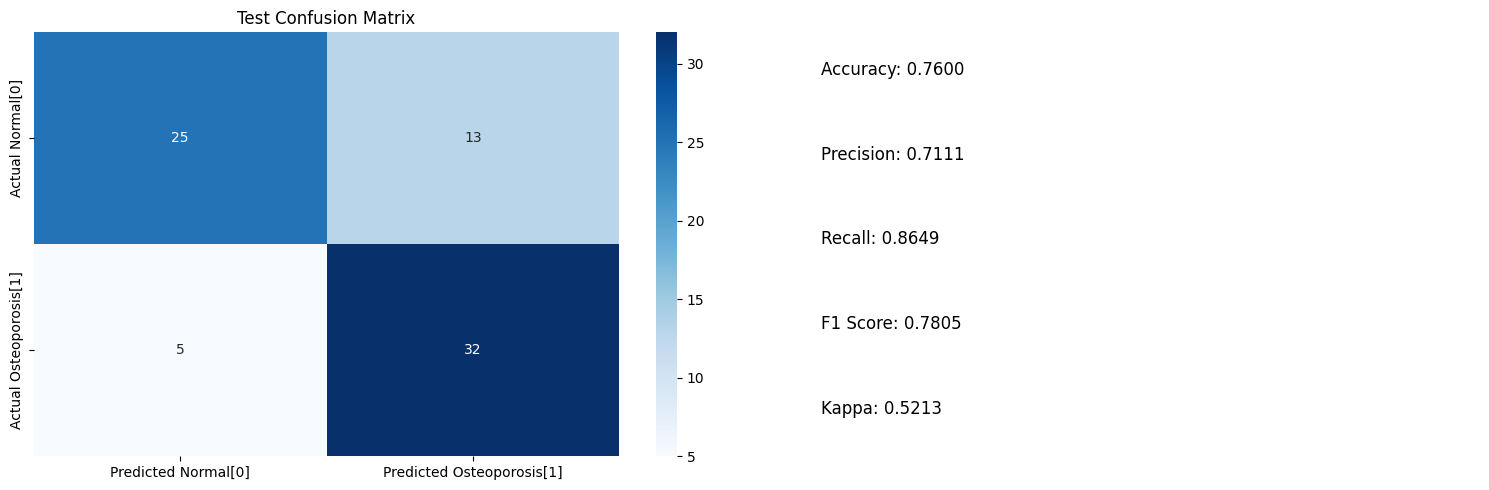

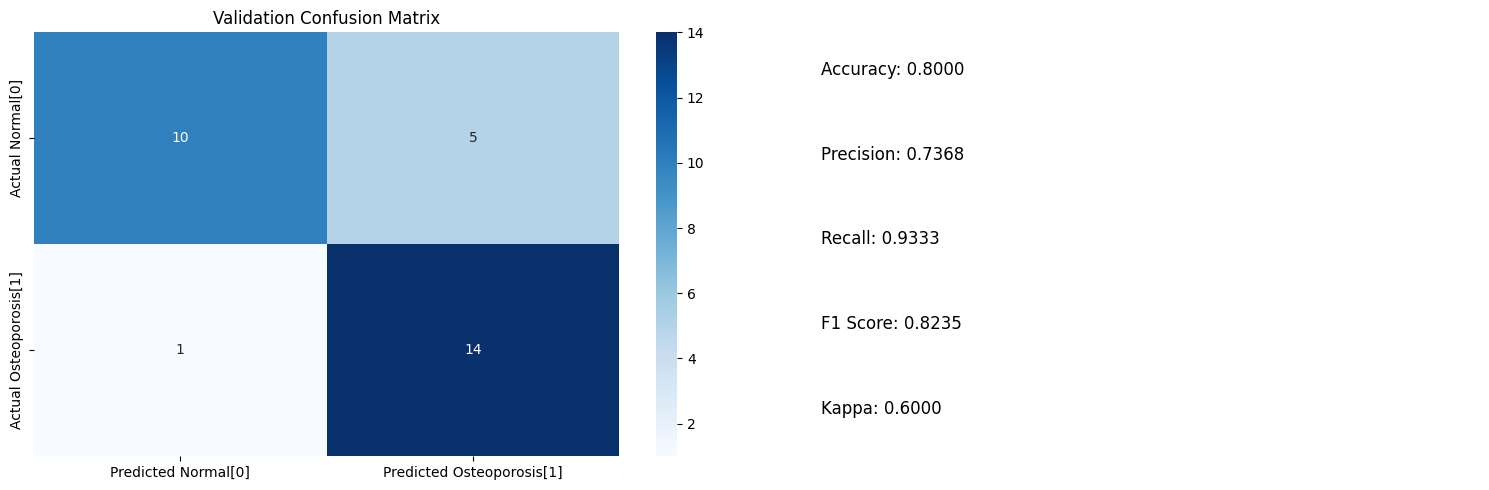

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# For accuracy graph (assuming you have training history)
train_accuracies = []  # Populate these during training
val_accuracies = []    # Populate these during validation

def plot_metrics(phase_name, cm, accuracy, precision, recall, f1, kappa):
    plt.figure(figsize=(15, 5))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Normal[0]', 'Predicted Osteoporosis[1]'],
                yticklabels=['Actual Normal[0]', 'Actual Osteoporosis[1]'])
    plt.title(f'{phase_name} Confusion Matrix')

    # Metrics Text
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.9, f'Accuracy: {accuracy:.4f}', fontsize=12)
    plt.text(0.1, 0.7, f'Precision: {precision:.4f}', fontsize=12)
    plt.text(0.1, 0.5, f'Recall: {recall:.4f}', fontsize=12)
    plt.text(0.1, 0.3, f'F1 Score: {f1:.4f}', fontsize=12)
    plt.text(0.1, 0.1, f"Kappa: {kappa:.4f}", fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def evaluate_model(loader, phase_name):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            preds = (outputs >= 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    plot_metrics(phase_name, cm, accuracy, precision, recall, f1, kappa)

    return accuracy



# Evaluate both sets
test_accuracy = evaluate_model(test_loader, 'Test')
val_accuracy = evaluate_model(val_loader, 'Validation')


# Swin Transformer Large Model

In [ ]:
# Step 5: Modified ViT Model with DWT Processing
from transformers import SwinModel

class SwinBinaryClassifier(nn.Module):
    def __init__(self, pretrained_model='microsoft/swin-large-patch4-window7-224'):
        super().__init__()
        self.swin = SwinModel.from_pretrained(pretrained_model)
        self.classifier = nn.Linear(self.swin.config.hidden_size * 4, 1)
        self.sigmoid = nn.Sigmoid()

        # Freeze Swin parameters
        for param in self.swin.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Apply Haar DWT
        x_dwt = dwt_haar(x)
        batch_size = x_dwt.size(0)

        # Reshape and process each subband
        x_dwt = x_dwt.view(batch_size, 4, 3, 112, 112)
        swin_outputs = []

        for i in range(4):
            subband = x_dwt[:, i, :, :, :]
            subband_up = F.interpolate(subband, size=(224, 224),
                                     mode='bilinear', align_corners=False)
            outputs = self.swin(subband_up)
            # Use mean pooling over sequence dimension
            pooled = outputs.last_hidden_state.mean(dim=1)
            swin_outputs.append(pooled)

        # Concatenate and classify
        combined = torch.cat(swin_outputs, dim=1)
        return self.sigmoid(self.classifier(combined))

# Initialize Swin model
model = SwinBinaryClassifier().to(device)

# Step 8: Loss and Optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/787M [00:00<?, ?B/s]

In [ ]:
# --------------------------
# 4. Training Loop
# --------------------------
num_epochs = 500
best_val_loss = float('inf')
patience = 20
history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []}

print(f"\n{'='*50}")
print(f"Starting training of {model.__class__.__name__}")
print(f"Batch size: {batch_size}, Epochs: {num_epochs}")
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
print(f"{'='*50}\n")

for epoch in range(num_epochs):
    epoch_start = time.time()

    # Training phase
    model.train()
    train_loss = 0.0
    with tqdm(train_loader, desc=f"Epoch {epoch+1:3d}/{num_epochs} [Train]", unit="batch") as pbar:
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    # Validation phase
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            predicted = (outputs >= 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate metrics
    epoch_train_loss = train_loss / len(train_dataset)
    epoch_val_loss = val_loss / len(val_dataset)
    val_acc = correct / total
    current_lr = optimizer.param_groups[0]['lr']

    # Update scheduler and history
    scheduler.step(epoch_val_loss)
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1

    # Epoch reporting
    epoch_time = time.time() - epoch_start
    print(f"\nEpoch {epoch+1:3d}/{num_epochs} | Time: {epoch_time:.1f}s")
    print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    print(f"Val Acc: {val_acc:.4f} | LR: {current_lr:.2e}")
    print(f"Early stopping counter: {patience_counter}/{patience}")
    print("-" * 60)

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


Starting training of SwinBinaryClassifier
Batch size: 32, Epochs: 500
Train samples: 267, Val samples: 30



Epoch   1/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.06s/batch, loss=0.6424]



Epoch   1/500 | Time: 34.7s
Train Loss: 0.6610 | Val Loss: 0.5806
Val Acc: 0.7667 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch   2/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.05s/batch, loss=0.6355]



Epoch   2/500 | Time: 33.1s
Train Loss: 0.5905 | Val Loss: 0.5024
Val Acc: 0.7333 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch   3/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.01s/batch, loss=0.6409]



Epoch   3/500 | Time: 34.4s
Train Loss: 0.5402 | Val Loss: 0.4950
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch   4/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.07s/batch, loss=0.6265]



Epoch   4/500 | Time: 33.5s
Train Loss: 0.5139 | Val Loss: 0.4540
Val Acc: 0.7667 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch   5/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.03s/batch, loss=0.2733]



Epoch   5/500 | Time: 30.4s
Train Loss: 0.5092 | Val Loss: 0.4589
Val Acc: 0.8333 | LR: 1.00e-03
Early stopping counter: 1/20
------------------------------------------------------------


Epoch   6/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.03s/batch, loss=0.5330]



Epoch   6/500 | Time: 34.3s
Train Loss: 0.4908 | Val Loss: 0.4395
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch   7/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.04s/batch, loss=0.5840]



Epoch   7/500 | Time: 30.4s
Train Loss: 0.4806 | Val Loss: 0.4428
Val Acc: 0.8333 | LR: 1.00e-03
Early stopping counter: 1/20
------------------------------------------------------------


Epoch   8/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.04s/batch, loss=0.5369]



Epoch   8/500 | Time: 34.6s
Train Loss: 0.4761 | Val Loss: 0.4333
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch   9/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.02s/batch, loss=0.4336]



Epoch   9/500 | Time: 30.3s
Train Loss: 0.4724 | Val Loss: 0.4559
Val Acc: 0.8333 | LR: 1.00e-03
Early stopping counter: 1/20
------------------------------------------------------------


Epoch  10/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.05s/batch, loss=0.4990]



Epoch  10/500 | Time: 30.4s
Train Loss: 0.4700 | Val Loss: 0.4351
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 2/20
------------------------------------------------------------


Epoch  11/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.02s/batch, loss=0.3051]



Epoch  11/500 | Time: 34.9s
Train Loss: 0.4430 | Val Loss: 0.4322
Val Acc: 0.8333 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch  12/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.05s/batch, loss=0.3850]



Epoch  12/500 | Time: 35.1s
Train Loss: 0.4441 | Val Loss: 0.4256
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch  13/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.05s/batch, loss=0.4392]



Epoch  13/500 | Time: 30.5s
Train Loss: 0.4409 | Val Loss: 0.4277
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 1/20
------------------------------------------------------------


Epoch  14/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.02s/batch, loss=0.2503]



Epoch  14/500 | Time: 32.8s
Train Loss: 0.4256 | Val Loss: 0.4246
Val Acc: 0.8333 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch  15/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.04s/batch, loss=0.2175]



Epoch  15/500 | Time: 30.5s
Train Loss: 0.4166 | Val Loss: 0.4265
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 1/20
------------------------------------------------------------


Epoch  16/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.04s/batch, loss=0.8460]



Epoch  16/500 | Time: 33.1s
Train Loss: 0.4215 | Val Loss: 0.4234
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 0/20
------------------------------------------------------------


Epoch  17/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.04s/batch, loss=0.3627]



Epoch  17/500 | Time: 30.4s
Train Loss: 0.4153 | Val Loss: 0.4316
Val Acc: 0.8333 | LR: 1.00e-03
Early stopping counter: 1/20
------------------------------------------------------------


Epoch  18/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.05s/batch, loss=0.4105]



Epoch  18/500 | Time: 30.5s
Train Loss: 0.4098 | Val Loss: 0.4262
Val Acc: 0.8333 | LR: 1.00e-03
Early stopping counter: 2/20
------------------------------------------------------------


Epoch  19/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.02s/batch, loss=0.3086]



Epoch  19/500 | Time: 30.2s
Train Loss: 0.4006 | Val Loss: 0.4262
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 3/20
------------------------------------------------------------


Epoch  20/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.03s/batch, loss=0.5882]



Epoch  20/500 | Time: 30.3s
Train Loss: 0.3999 | Val Loss: 0.4346
Val Acc: 0.8000 | LR: 1.00e-03
Early stopping counter: 4/20
------------------------------------------------------------


Epoch  21/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.04s/batch, loss=0.2803]



Epoch  21/500 | Time: 30.4s
Train Loss: 0.4010 | Val Loss: 0.4347
Val Acc: 0.8667 | LR: 1.00e-03
Early stopping counter: 5/20
------------------------------------------------------------


Epoch  22/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.03s/batch, loss=0.2108]



Epoch  22/500 | Time: 30.4s
Train Loss: 0.3856 | Val Loss: 0.4373
Val Acc: 0.8333 | LR: 1.00e-03
Early stopping counter: 6/20
------------------------------------------------------------


Epoch  23/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.02s/batch, loss=0.4349]



Epoch  23/500 | Time: 30.3s
Train Loss: 0.3896 | Val Loss: 0.4332
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 7/20
------------------------------------------------------------


Epoch  24/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.03s/batch, loss=0.3155]



Epoch  24/500 | Time: 30.4s
Train Loss: 0.3799 | Val Loss: 0.4290
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 8/20
------------------------------------------------------------


Epoch  25/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.04s/batch, loss=0.2807]



Epoch  25/500 | Time: 30.4s
Train Loss: 0.3788 | Val Loss: 0.4293
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 9/20
------------------------------------------------------------


Epoch  26/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.04s/batch, loss=0.4567]



Epoch  26/500 | Time: 30.5s
Train Loss: 0.3753 | Val Loss: 0.4301
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 10/20
------------------------------------------------------------


Epoch  27/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.04s/batch, loss=0.3546]



Epoch  27/500 | Time: 30.5s
Train Loss: 0.3813 | Val Loss: 0.4300
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 11/20
------------------------------------------------------------


Epoch  28/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.03s/batch, loss=0.3944]



Epoch  28/500 | Time: 30.4s
Train Loss: 0.3719 | Val Loss: 0.4299
Val Acc: 0.8000 | LR: 1.00e-04
Early stopping counter: 12/20
------------------------------------------------------------


Epoch  29/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.04s/batch, loss=0.3244]



Epoch  29/500 | Time: 30.4s
Train Loss: 0.3748 | Val Loss: 0.4300
Val Acc: 0.8000 | LR: 1.00e-05
Early stopping counter: 13/20
------------------------------------------------------------


Epoch  30/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.04s/batch, loss=0.7167]



Epoch  30/500 | Time: 30.4s
Train Loss: 0.3715 | Val Loss: 0.4301
Val Acc: 0.8000 | LR: 1.00e-05
Early stopping counter: 14/20
------------------------------------------------------------


Epoch  31/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.04s/batch, loss=0.4241]



Epoch  31/500 | Time: 30.5s
Train Loss: 0.3829 | Val Loss: 0.4303
Val Acc: 0.8000 | LR: 1.00e-05
Early stopping counter: 15/20
------------------------------------------------------------


Epoch  32/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.03s/batch, loss=0.4432]



Epoch  32/500 | Time: 30.4s
Train Loss: 0.3812 | Val Loss: 0.4303
Val Acc: 0.8000 | LR: 1.00e-05
Early stopping counter: 16/20
------------------------------------------------------------


Epoch  33/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.03s/batch, loss=0.2761]



Epoch  33/500 | Time: 30.4s
Train Loss: 0.3725 | Val Loss: 0.4302
Val Acc: 0.8000 | LR: 1.00e-05
Early stopping counter: 17/20
------------------------------------------------------------


Epoch  34/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.03s/batch, loss=0.3129]



Epoch  34/500 | Time: 30.4s
Train Loss: 0.3769 | Val Loss: 0.4303
Val Acc: 0.8000 | LR: 1.00e-05
Early stopping counter: 18/20
------------------------------------------------------------


Epoch  35/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.03s/batch, loss=0.6041]



Epoch  35/500 | Time: 30.3s
Train Loss: 0.3791 | Val Loss: 0.4303
Val Acc: 0.8000 | LR: 1.00e-06
Early stopping counter: 19/20
------------------------------------------------------------


Epoch  36/500 [Train]: 100%|██████████| 9/9 [00:27<00:00,  3.03s/batch, loss=0.4257]



Epoch  36/500 | Time: 30.3s
Train Loss: 0.3836 | Val Loss: 0.4303
Val Acc: 0.8000 | LR: 1.00e-06
Early stopping counter: 20/20
------------------------------------------------------------
Early stopping triggered at epoch 36


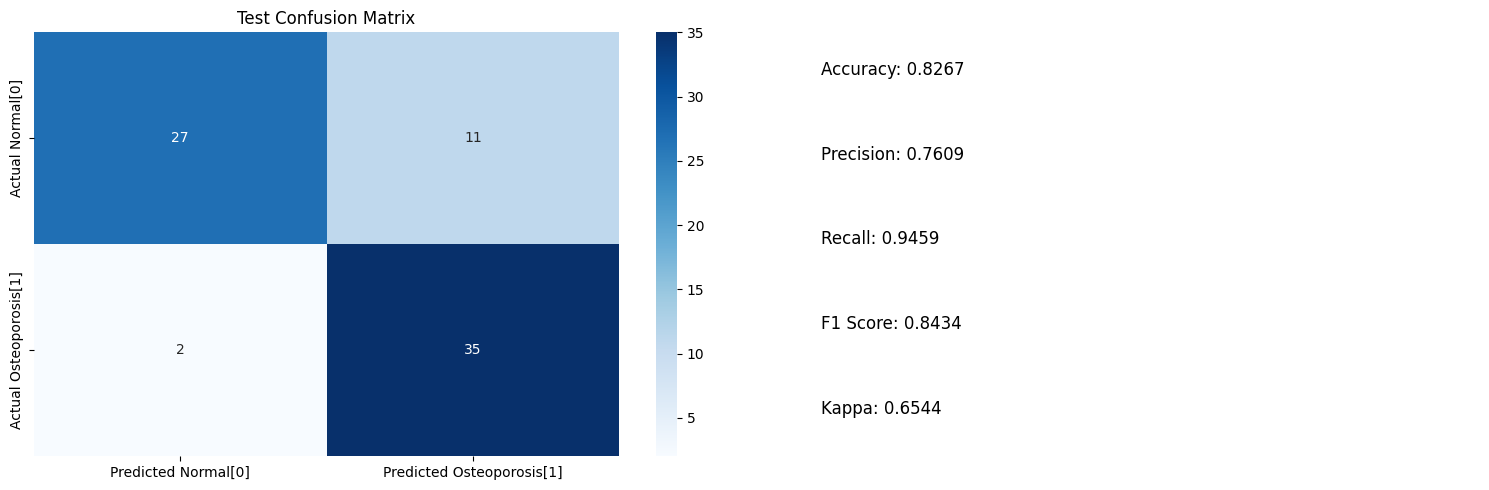

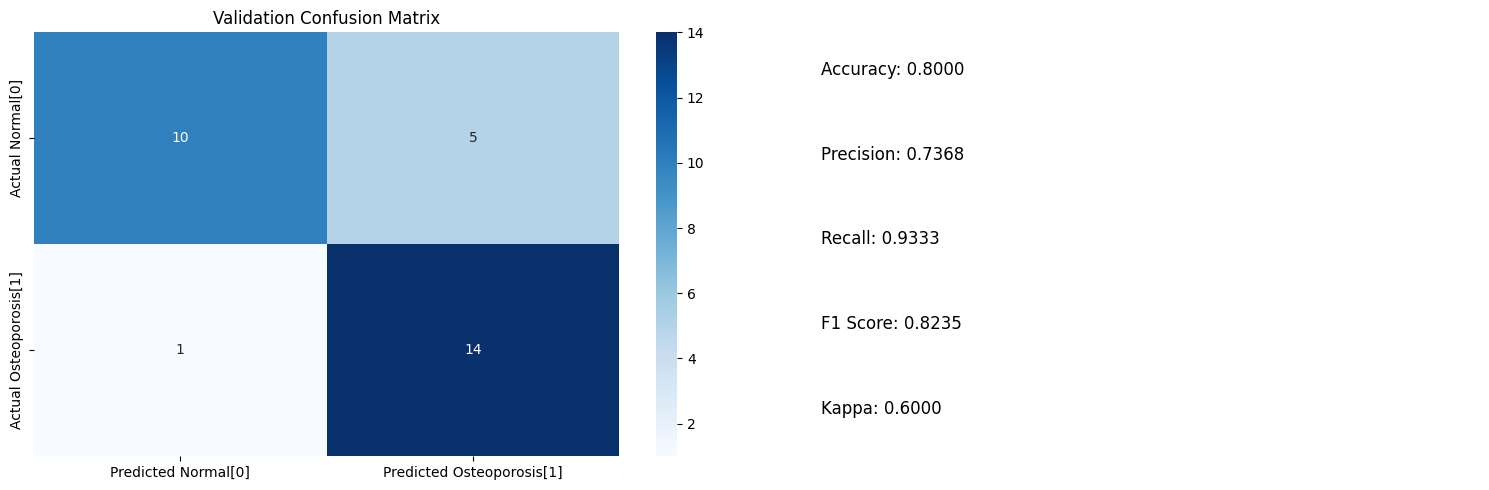

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# For accuracy graph (assuming you have training history)
train_accuracies = []  # Populate these during training
val_accuracies = []    # Populate these during validation

def plot_metrics(phase_name, cm, accuracy, precision, recall, f1, kappa):
    plt.figure(figsize=(15, 5))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Normal[0]', 'Predicted Osteoporosis[1]'],
                yticklabels=['Actual Normal[0]', 'Actual Osteoporosis[1]'])
    plt.title(f'{phase_name} Confusion Matrix')

    # Metrics Text
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.9, f'Accuracy: {accuracy:.4f}', fontsize=12)
    plt.text(0.1, 0.7, f'Precision: {precision:.4f}', fontsize=12)
    plt.text(0.1, 0.5, f'Recall: {recall:.4f}', fontsize=12)
    plt.text(0.1, 0.3, f'F1 Score: {f1:.4f}', fontsize=12)
    plt.text(0.1, 0.1, f"Kappa: {kappa:.4f}", fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def evaluate_model(loader, phase_name):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            preds = (outputs >= 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    plot_metrics(phase_name, cm, accuracy, precision, recall, f1, kappa)

    return accuracy



# Evaluate both sets
test_accuracy = evaluate_model(test_loader, 'Test')
val_accuracy = evaluate_model(val_loader, 'Validation')
